In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import glob
import time
import os, shutil
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def removeFolderContent(folder):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

In [3]:
def write_ply(filename, points, colors):
    """Export 3D points and colors to a .ply file"""
    points = points.reshape(-1, 3)
    colors = colors.reshape(-1, 3)
    mask = np.isfinite(points).all(axis=1) & (points[:, 2] > 0)

    with open(filename, 'w') as f:
        f.write(f'''ply
format ascii 1.0
element vertex {len(points)}
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
''')
        for p, c in zip(points, colors):
            f.write(f'{p[0]} {p[1]} {p[2]} {int(c[2])} {int(c[1])} {int(c[0])}\n')  # BGR -> RGB


In [54]:
cam1 = cv2.VideoCapture(0)
cam2 = cv2.VideoCapture(1)
if not cam1.isOpened() or not cam2.isOpened():
    print("Error: Could not open one or both cameras")
    exit()

Test Cameras

In [56]:
while True:
    ret1, frame1 = cam1.read()
    ret2, frame2 = cam2.read()

    if ret1 and ret2:
        cv2.imshow('Left Camera', frame1)
        cv2.imshow('Right Camera', frame2)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cv2.destroyAllWindows()

In [53]:
cam1.release()
cam2.release()

## Calibration

In [57]:
CHESSBOARD_SIZE = (8,6)

### Capture Chessboard

In [67]:
CALIBRATION_PATH = "calibration/"
removeFolderContent(CALIBRATION_PATH)
os.makedirs(f"{CALIBRATION_PATH}/left")
os.makedirs(f"{CALIBRATION_PATH}/right")

In [68]:
index = 1
while True:
    ret1, frame1 = cam1.read()
    ret2, frame2 = cam2.read()

    if ret1 and ret2:
        cv2.imshow('Left Camera', frame1)
        cv2.imshow('Right Camera', frame2)

        # Save the images when 's' is pressed
        key = cv2.waitKey(1)
        if key & 0xFF == ord('s'):
            cv2.imwrite(f'{CALIBRATION_PATH}/left/{index}.jpg', frame1)
            cv2.imwrite(f'{CALIBRATION_PATH}/right/{index}.jpg', frame2)
            print(f"Saved image pair {index}")
            index += 1
        # Break on 'q' key press
        if key & 0xFF == ord('q'):
            break
    else:
        print("Failed to capture image pair")

cv2.destroyAllWindows()

Saved image pair 1
Saved image pair 2
Saved image pair 3
Saved image pair 4


### Calibrate

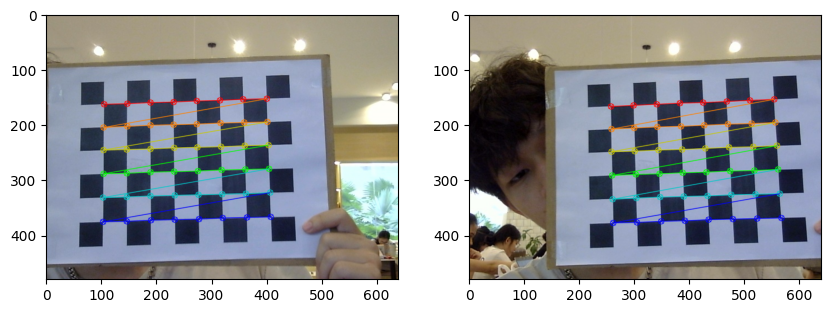

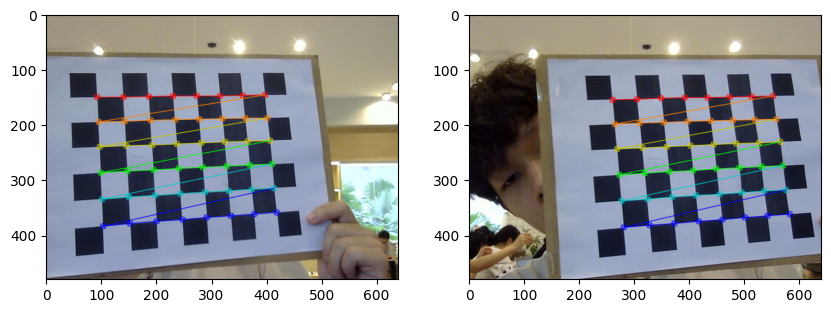

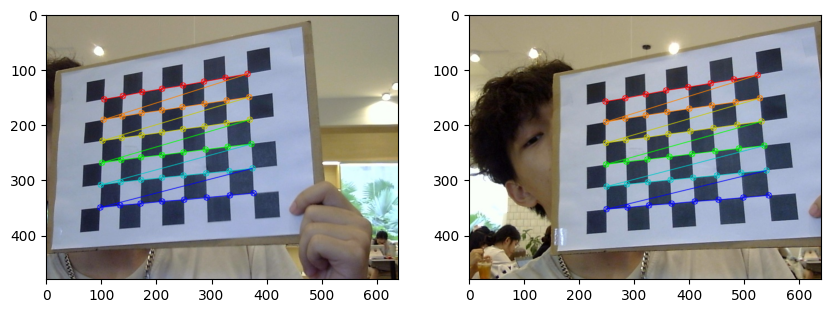

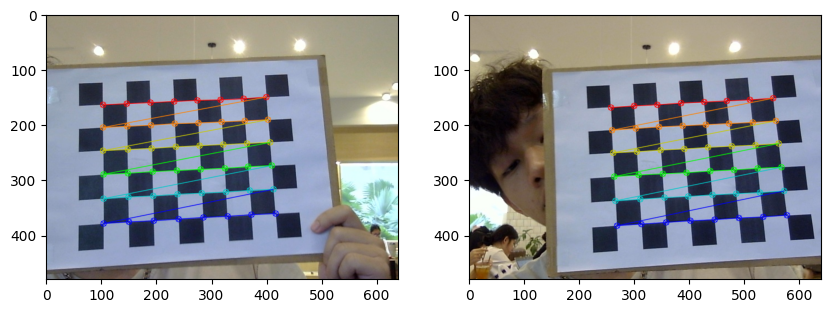

In [69]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp = np.zeros(
    (CHESSBOARD_SIZE[0]*CHESSBOARD_SIZE[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:CHESSBOARD_SIZE[0],
                       0:CHESSBOARD_SIZE[1]].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = []  # 3d point in real world space
imgpointsL = []  # 2d points in image plane.
imgpointsR = []  # 2d points in image plane.

imagesLeft = glob.glob('./calibration/left/*.jpg')
imagesRight = glob.glob('./calibration/right/*.jpg')

for imgLeft, imgRight in zip(imagesLeft, imagesRight):
    imgL = cv2.imread(imgLeft)
    imgR = cv2.imread(imgRight)
    grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
    grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    retL, cornersL = cv2.findChessboardCorners(
        imgL, CHESSBOARD_SIZE, None)
    retR, cornersR = cv2.findChessboardCorners(
        imgR, CHESSBOARD_SIZE, None)

    if retL and retR == True:
        objpoints.append(objp)

        cornersL = cv2.cornerSubPix(
            grayL, cornersL, (11, 11), (-1, -1), criteria)
        imgpointsL.append(cornersL)
        cornersR = cv2.cornerSubPix(
            grayR, cornersR, (11, 11), (-1, -1), criteria)
        imgpointsR.append(cornersR)

        # Draw and display the corners
        cv2.drawChessboardCorners(
            imgL, CHESSBOARD_SIZE, cornersL, retL)
        cv2.drawChessboardCorners(
            imgR, CHESSBOARD_SIZE, cornersR, retR)
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(imgL[:, :, ::-1])
        plt.subplot(1, 2, 2)
        plt.imshow(imgR[:, :, ::-1])

In [70]:
retL, mtxL, distL, rvecsL, tvecsL = cv2.calibrateCamera(objpoints, imgpointsL, grayL.shape[::-1], None, None)
print(f"Left camera\nMatrix: \n{mtxL}\nDistortion coefficients : \n{distL}")
heightL, widthL, channelsL = imgL.shape
newCameraMatrixL, roiL = cv2.getOptimalNewCameraMatrix(mtxL, distL, (widthL, heightL), 1, (widthL, heightL))
print()

retR, mtxR, distR, rvecsR, tvecsR = cv2.calibrateCamera(objpoints, imgpointsR, grayR.shape[::-1], None, None)
print(f"Right camera\nMatrix is \n{mtxR}\nDistortion coefficients : \n{distR}")
heightR, widthR, channelsR = imgR.shape
newCameraMatrixR, roiR = cv2.getOptimalNewCameraMatrix(mtxR, distR, (widthR, heightR), 1, (widthR, heightR))

Left camera
Matrix: 
[[918.71587643   0.         297.51449536]
 [  0.         918.93615978 253.29206523]
 [  0.           0.           1.        ]]
Distortion coefficients : 
[[ 1.39941731e-01 -4.61274150e+00  1.55785104e-02 -1.74542070e-02
   4.08601539e+01]]

Right camera
Matrix is 
[[888.96077073   0.         292.17140603]
 [  0.         894.36570432 300.55884327]
 [  0.           0.           1.        ]]
Distortion coefficients : 
[[-0.23509851  1.2556708   0.01377938 -0.00189888 -0.35070062]]


In [71]:
flags = 0
flags |= cv2.CALIB_FIX_INTRINSIC
criteria_stereo = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 30, 0.001)
retStereo, newCameraMatrixL, distL, newCameraMatrixR, distR, R, T, essentialMatrix, fundamentalMatrix = cv2.stereoCalibrate(objpoints, imgpointsL, imgpointsR, newCameraMatrixL, distL, newCameraMatrixR, distR, grayL.shape[::-1], criteria_stereo, flags)

In [72]:
rectifyScale = 1
rectL, rectR, projMatrixL, projMatrixR, Q, roiL, roiR = cv2.stereoRectify(
    newCameraMatrixL, distL, newCameraMatrixR, distR, grayL.shape[::-1], R, T, rectifyScale, (0, 0))
print(Q)

stereoMapL = cv2.initUndistortRectifyMap(newCameraMatrixL, distL, rectL, projMatrixL, grayL.shape[::-1], cv2.CV_16SC2)
stereoMapR = cv2.initUndistortRectifyMap(newCameraMatrixR, distR, rectR, projMatrixR, grayR.shape[::-1], cv2.CV_16SC2)

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -6.88744618e+02]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -2.90079258e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  8.98436252e+02]
 [ 0.00000000e+00  0.00000000e+00 -2.62284313e-01  0.00000000e+00]]


In [73]:
cv_file = cv2.FileStorage('stereoMap.xml', cv2.FILE_STORAGE_WRITE)
cv_file.write("stereoMapL_x", stereoMapL[0])
cv_file.write("stereoMapL_y", stereoMapL[1])
cv_file.write("stereoMapR_x", stereoMapR[0])
cv_file.write("stereoMapR_y", stereoMapR[1])
cv_file.release()

## Depth Map

In [74]:
cv_file = cv2.FileStorage("stereoMap.xml", cv2.FILE_STORAGE_READ)
stereoMapL_x = cv_file.getNode("stereoMapL_x").mat()
stereoMapL_y = cv_file.getNode("stereoMapL_y").mat()
stereoMapR_x = cv_file.getNode("stereoMapR_x").mat()
stereoMapR_y = cv_file.getNode("stereoMapR_y").mat()
cv_file.release()

### Capture video

In [89]:
VIDEO_PATH = "video"
removeFolderContent(VIDEO_PATH)

In [90]:
frame_width = int(cam1.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cam1.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = 20.0

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out1 = cv2.VideoWriter(f'{VIDEO_PATH}/left.avi', fourcc, fps, (frame_width, frame_height))
out2 = cv2.VideoWriter(f'{VIDEO_PATH}/right.avi', fourcc, fps, (frame_width, frame_height))

while True:
    ret1, frame1 = cam1.read()
    ret2, frame2 = cam2.read()

    if ret1 and ret2:
        out1.write(frame1)
        out2.write(frame2)

        cv2.imshow('Left Camera', frame1)
        cv2.imshow('Right Camera', frame2)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        print("Failed to grab frames.")
        break

out1.release()
out2.release()
cv2.destroyAllWindows()

### Test Block Matching

In [80]:
FRAME_INDEX = 50

#### Test frame

In [81]:
video_right = cv2.VideoCapture('video/right.avi')
video_left = cv2.VideoCapture('video/left.avi')

frame_number_right = int(FRAME_INDEX)
frame_number_left = int(FRAME_INDEX)

video_right.set(cv2.CAP_PROP_POS_FRAMES, frame_number_right)
video_left.set(cv2.CAP_PROP_POS_FRAMES, frame_number_left)

ret_right, frame_right = video_right.read()
ret_left, frame_left = video_left.read()

if ret_left and ret_right:
    print("Frames extracted successfully.")
else:
    print("Failed to read one or both frames.")

video_right.release()
video_left.release()

Frames extracted successfully.


In [82]:
with open("stereo_config.json", "r") as f:
    configs = json.load(f)


def nothing(x):
    pass


MAX_CONFIG = {
    "numDisparities": 17,
    "blockSize": 15,
    "P1": 8*2*(15**2),
    "P2": 32*2*(15**2),
    "preFilterCap": 62,
    "uniquenessRatio": 100,
    "speckleRange": 100,
    "speckleWindowSize": 25,
    "disp12MaxDiff": 25,
    "minDisparity": 25,
    "sigma": 40,
    "lmbda": 10
}

cv2.namedWindow('disp', cv2.WINDOW_NORMAL)
if configs:
    for key, value in configs.items():
        cv2.createTrackbar(key, "disp", value, MAX_CONFIG[key], nothing)
else:
    for key, value in MAX_CONFIG.items():
        cv2.createTrackbar(key, "disp", 1, MAX_CONFIG[key], nothing)

stereo = cv2.StereoSGBM_create()
while True:
    numDisparities = cv2.getTrackbarPos('numDisparities', 'disp')*16 + 16
    blockSize = cv2.getTrackbarPos('blockSize', 'disp')*2 + 1
    P1 = cv2.getTrackbarPos('P1', 'disp')
    P2 = cv2.getTrackbarPos('P2', 'disp')
    preFilterCap = cv2.getTrackbarPos('preFilterCap', 'disp') + 1
    uniquenessRatio = cv2.getTrackbarPos('uniquenessRatio', 'disp')
    speckleRange = cv2.getTrackbarPos('speckleRange', 'disp')
    speckleWindowSize = cv2.getTrackbarPos('speckleWindowSize', 'disp')*2
    disp12MaxDiff = cv2.getTrackbarPos('disp12MaxDiff', 'disp')
    minDisparity = cv2.getTrackbarPos('minDisparity', 'disp')

    stereo.setNumDisparities(numDisparities)
    stereo.setBlockSize(blockSize)
    stereo.setP1(P1)
    stereo.setP2(P2)
    stereo.setPreFilterCap(preFilterCap)
    stereo.setUniquenessRatio(uniquenessRatio)
    stereo.setSpeckleRange(speckleRange)
    stereo.setSpeckleWindowSize(speckleWindowSize)
    stereo.setDisp12MaxDiff(disp12MaxDiff)
    stereo.setMinDisparity(minDisparity)

    imgL_gray = cv2.cvtColor(frame_left, cv2.COLOR_BGR2GRAY)
    imgR_gray = cv2.cvtColor(frame_right, cv2.COLOR_BGR2GRAY)

    Left_nice = cv2.remap(imgL_gray, stereoMapL_x,
                          stereoMapL_y, cv2.INTER_LINEAR)
    Right_nice = cv2.remap(imgR_gray, stereoMapR_x,
                           stereoMapR_y, cv2.INTER_LINEAR)

    cv2.imshow("left", Left_nice)
    cv2.imshow("right", Right_nice)

    sigma = 2.0 / (cv2.getTrackbarPos('sigma', 'disp') + 1) + 0.8
    lmbda = cv2.getTrackbarPos('lmbda', 'disp')*1000
    right_matcher = cv2.ximgproc.createRightMatcher(stereo);
    left_disparity = stereo.compute(Left_nice, Right_nice)
    right_disparity = stereo.compute(Right_nice, Left_nice)

    wls_filter = cv2.ximgproc.createDisparityWLSFilter(stereo);
    wls_filter.setLambda(lmbda);
    wls_filter.setSigmaColor(sigma);
    filtered_disp = wls_filter.filter(left_disparity, Left_nice, disparity_map_right=right_disparity);

    filtered_disp = filtered_disp.astype(np.float32)
    filtered_disp = (filtered_disp/16.0 - minDisparity)/numDisparities
    cv2.imshow("disp", filtered_disp)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    time.sleep(100/1000)

with open("stereo_config.json", "w") as f:
    json.dump({
        "numDisparities": cv2.getTrackbarPos('numDisparities', 'disp'),
        "blockSize": cv2.getTrackbarPos('blockSize', 'disp'),
        "P1": cv2.getTrackbarPos('P1', 'disp'),
        "P2": cv2.getTrackbarPos('P2', 'disp'),
        "preFilterCap": cv2.getTrackbarPos('preFilterCap', 'disp'),
        "uniquenessRatio": cv2.getTrackbarPos('uniquenessRatio', 'disp'),
        "speckleRange": cv2.getTrackbarPos('speckleRange', 'disp'),
        "speckleWindowSize": cv2.getTrackbarPos('speckleWindowSize', 'disp'),
        "disp12MaxDiff": cv2.getTrackbarPos('disp12MaxDiff', 'disp'),
        "minDisparity": cv2.getTrackbarPos('minDisparity', 'disp'),
        "sigma": cv2.getTrackbarPos('sigma', 'disp'),
        "lmbda": cv2.getTrackbarPos('lmbda', 'disp')
    }, f)

cv2.destroyAllWindows()

#### Test video

In [92]:
with open("stereo_config.json", "r") as f:
    configs = json.load(f)


def nothing(x):
    pass


MAX_CONFIG = {
    "numDisparities": 17,
    "blockSize": 15,
    "P1": 8*2*(15**2),
    "P2": 32*2*(15**2),
    "preFilterCap": 62,
    "uniquenessRatio": 100,
    "speckleRange": 100,
    "speckleWindowSize": 25,
    "disp12MaxDiff": 25,
    "minDisparity": 25,
    "sigma": 40,
    "lmbda": 10
}
video_right = cv2.VideoCapture('video/right.avi')
video_left = cv2.VideoCapture('video/left.avi')

cv2.namedWindow('disp', cv2.WINDOW_NORMAL)
if configs:
    for key, value in configs.items():
        cv2.createTrackbar(key, "disp", value, MAX_CONFIG[key], nothing)
else:
    for key, value in MAX_CONFIG.items():
        cv2.createTrackbar(key, "disp", 1, MAX_CONFIG[key], nothing)

stereo = cv2.StereoSGBM_create()
while True:
    retL, imgL = video_right.read()
    retR, imgR = video_left.read()

    if not retL or not retR:
        break

    numDisparities = cv2.getTrackbarPos('numDisparities', 'disp')*16 + 16
    blockSize = cv2.getTrackbarPos('blockSize', 'disp')*2 + 1
    P1 = cv2.getTrackbarPos('P1', 'disp')
    P2 = cv2.getTrackbarPos('P2', 'disp')
    preFilterCap = cv2.getTrackbarPos('preFilterCap', 'disp') + 1
    uniquenessRatio = cv2.getTrackbarPos('uniquenessRatio', 'disp')
    speckleRange = cv2.getTrackbarPos('speckleRange', 'disp')
    speckleWindowSize = cv2.getTrackbarPos('speckleWindowSize', 'disp')*2
    disp12MaxDiff = cv2.getTrackbarPos('disp12MaxDiff', 'disp')
    minDisparity = cv2.getTrackbarPos('minDisparity', 'disp')

    stereo.setNumDisparities(numDisparities)
    stereo.setBlockSize(blockSize)
    stereo.setP1(P1)
    stereo.setP2(P2)
    stereo.setPreFilterCap(preFilterCap)
    stereo.setUniquenessRatio(uniquenessRatio)
    stereo.setSpeckleRange(speckleRange)
    stereo.setSpeckleWindowSize(speckleWindowSize)
    stereo.setDisp12MaxDiff(disp12MaxDiff)
    stereo.setMinDisparity(minDisparity)

    imgL_gray = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
    imgR_gray = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

    Left_nice = cv2.remap(imgL_gray, stereoMapL_x,
                          stereoMapL_y, cv2.INTER_LINEAR)
    Right_nice = cv2.remap(imgR_gray, stereoMapR_x,
                           stereoMapR_y, cv2.INTER_LINEAR)

    cv2.imshow("left", Left_nice)
    cv2.imshow("right", Right_nice)

    sigma = 2.0 / (cv2.getTrackbarPos('sigma', 'disp') + 1) + 0.8
    lmbda = cv2.getTrackbarPos('lmbda', 'disp')*1000
    right_matcher = cv2.ximgproc.createRightMatcher(stereo)
    left_disparity = stereo.compute(Left_nice, Right_nice)
    right_disparity = stereo.compute(Right_nice, Left_nice)

    wls_filter = cv2.ximgproc.createDisparityWLSFilter(stereo)
    wls_filter.setLambda(lmbda)
    wls_filter.setSigmaColor(sigma)
    filtered_disp = wls_filter.filter(
        left_disparity, Left_nice, disparity_map_right=right_disparity)

    filtered_disp = filtered_disp.astype(np.float32)
    filtered_disp = (filtered_disp/16.0 - minDisparity)/numDisparities
    cv2.imshow("disp", filtered_disp)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    time.sleep(100/1000)

with open("stereo_config.json", "w") as f:
    json.dump({
        "numDisparities": cv2.getTrackbarPos('numDisparities', 'disp'),
        "blockSize": cv2.getTrackbarPos('blockSize', 'disp'),
        "P1": cv2.getTrackbarPos('P1', 'disp'),
        "P2": cv2.getTrackbarPos('P2', 'disp'),
        "preFilterCap": cv2.getTrackbarPos('preFilterCap', 'disp'),
        "uniquenessRatio": cv2.getTrackbarPos('uniquenessRatio', 'disp'),
        "speckleRange": cv2.getTrackbarPos('speckleRange', 'disp'),
        "speckleWindowSize": cv2.getTrackbarPos('speckleWindowSize', 'disp'),
        "disp12MaxDiff": cv2.getTrackbarPos('disp12MaxDiff', 'disp'),
        "minDisparity": cv2.getTrackbarPos('minDisparity', 'disp'),
        "sigma": cv2.getTrackbarPos('sigma', 'disp'),
        "lmbda": cv2.getTrackbarPos('lmbda', 'disp')
    }, f)

video_right.release()
video_left.release()
cv2.destroyAllWindows()

### Compute Depth Map

In [84]:
video_right = cv2.VideoCapture('video/right.avi')
video_left = cv2.VideoCapture('video/left.avi')

while True:
    retL, imgL = video_right.read()
    retR, imgR = video_left.read()

    if not retL or not retR:
        break

    imgL_gray = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
    imgR_gray = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

    Left_nice = cv2.remap(imgL_gray, stereoMapL_x,
                          stereoMapL_y, cv2.INTER_LINEAR)
    Right_nice = cv2.remap(imgR_gray, stereoMapR_x,
                           stereoMapR_y, cv2.INTER_LINEAR)

    cv2.imshow("left", Left_nice)
    cv2.imshow("right", Right_nice)

    left_disparity = stereo.compute(Left_nice, Right_nice)
    right_disparity = stereo.compute(Right_nice, Left_nice)

    filtered_disp = wls_filter.filter(left_disparity, Left_nice, disparity_map_right=right_disparity);
    filtered_disp = filtered_disp.astype(np.float32)
    filtered_disp = (filtered_disp/16.0 - minDisparity)/numDisparities
    cv2.imshow("disp", filtered_disp)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    time.sleep(10/1000)


video_right.release()
video_left.release()
cv2.destroyAllWindows()

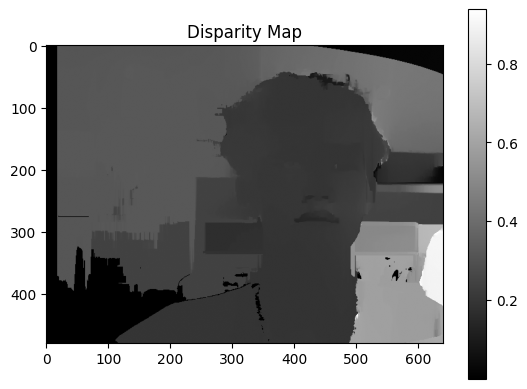

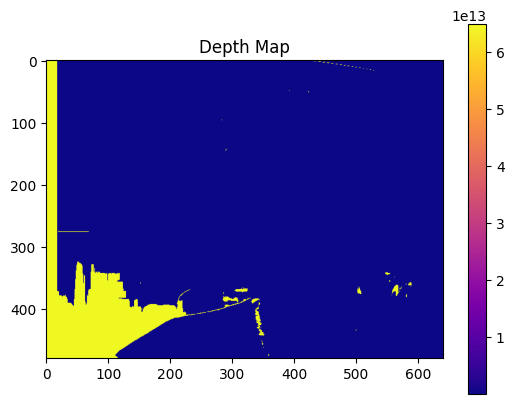

In [85]:
filtered_disp[filtered_disp <= 0] = 1e-9
plt.imshow(filtered_disp, 'gray')
plt.title('Disparity Map')
plt.colorbar()
plt.show()

focal_length = 720
baseline = 90

# Compute depth map
depth_map = (focal_length * baseline) / filtered_disp


# Display depth map
plt.imshow(depth_map, cmap='plasma')
plt.colorbar()
plt.title('Depth Map')
plt.show()

In [86]:
points_3D = cv2.reprojectImageTo3D(filtered_disp, Q, handleMissingValues=True)
filename = f'output.ply'
write_ply(filename, points_3D, imgL)

In [87]:
pcd = o3d.io.read_point_cloud("output.ply")
o3d.visualization.draw_geometries([pcd])

## Distance detection

In [ ]:
cv_file = cv2.FileStorage("stereoMap.xml", cv2.FILE_STORAGE_READ)
Left_Stereo_Map_x = cv_file.getNode("stereoMapL_x").mat()
Left_Stereo_Map_y = cv_file.getNode("stereoMapL_y").mat()
Right_Stereo_Map_x = cv_file.getNode("stereoMapR_x").mat()
Right_Stereo_Map_y = cv_file.getNode("stereoMapR_y").mat()
cv_file.release()

In [ ]:
with open("stereo_config.json", "r") as f:
    configs = json.load(f)

stereo = cv2.StereoBM_create()
stereo.setNumDisparities(configs["numDisparities"][0]*16)
stereo.setBlockSize(configs["blockSize"][0]*2 + 1)
stereo.setPreFilterType(configs["preFilterType"][0])
stereo.setPreFilterSize(configs["preFilterSize"][0]*2 + 7)
stereo.setPreFilterCap(configs["preFilterCap"][0]+1)
stereo.setTextureThreshold(configs["textureThreshold"][0])
stereo.setUniquenessRatio(configs["uniquenessRatio"][0])
stereo.setSpeckleRange(configs["speckleRange"][0])
stereo.setSpeckleWindowSize(configs["speckleWindowSize"][0]*2)
stereo.setDisp12MaxDiff(configs["disp12MaxDiff"][0])
stereo.setMinDisparity(configs["minDisparity"][0])

clicked_point = None

def on_mouse_click(event, x, y, flags, param):
    global clicked_point
    if event == cv2.EVENT_LBUTTONDOWN:
        clicked_point = (x, y)

cv2.namedWindow('depth')
cv2.setMouseCallback("depth", on_mouse_click)

while True:
    retL, imgL = cam1.read()
    retR, imgR = cam2.read()

    if not retL or not retR:
        continue

    Left_nice= cv2.remap(imgL, Left_Stereo_Map_x, Left_Stereo_Map_y, cv2.INTER_LINEAR)
    Right_nice= cv2.remap(imgR, Right_Stereo_Map_x, Right_Stereo_Map_y, cv2.INTER_LINEAR)

    imgL_gray = cv2.cvtColor(Left_nice,cv2.COLOR_BGR2GRAY)
    imgR_gray = cv2.cvtColor(Right_nice,cv2.COLOR_BGR2GRAY)

    disparity = stereo.compute(imgL_gray, imgR_gray)
    disparity = disparity.astype(np.float32)
    disparity = disparity / 16.0 * numDisparities

    disp_vis = cv2.normalize(disparity, None, 0, 255, cv2.NORM_MINMAX)
    disp_vis = np.uint8(disp_vis)
    cv2.imshow("disp", disp_vis)
    cv2.imshow("left", imgL)
    cv2.imshow("right", imgR)

    # Camera parameters from calibration
    focal_length = 1300  # in pixels
    baseline = 0.075     # in meters

    with np.errstate(divide="ignore"):
        depth_map = (focal_length * baseline) / disparity

    depth_display = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX)
    depth_display = np.uint8(depth_display)
    depth_color = cv2.applyColorMap(depth_display, cv2.COLORMAP_JET)
    depth_display_with_text = depth_color.copy()

    if clicked_point is not None:
        x, y = clicked_point
        if 0 <= x < depth_map.shape[1] and 0 <= y < depth_map.shape[0]:
            depth_val = depth_map[y, x]*100
            if depth_val > 0:
                text = f"{depth_val:.2f} m"
                cv2.circle(depth_display_with_text, (x, y), 5, (255, 255, 255), -1)
                cv2.putText(depth_display_with_text, text, (x + 10, y - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

                # Show warning or "cool" based on that depth
                if depth_val <= 0.2:
                    cv2.putText(depth_display_with_text, "Too close, get away!", (30, 50),
                                cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 3)
                else:
                    cv2.putText(depth_display_with_text, "Cool", (30, 50),
                                cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)
            else:
                cv2.putText(depth_display_with_text, "Invalid point", (30, 50),
                            cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), 2)
    cv2.imshow("depth", depth_display_with_text)

    if cv2.waitKey(1) == 27:
        break
cv2.destroyAllWindows()